In [3]:
import pandas as pd
import numpy as np
import talib as ta
import pyupbit as up
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

In [56]:
df = up.get_ohlcv(ticker="KRW-BTC", interval="day", count=3000)
df.to_csv('bitcoin_data.csv')

In [69]:
df = pd.read_csv('bitcoin_data.csv')
df.drop([2218], axis=0, inplace=True)
df

,Unnamed: 0,open,high,low,close,volume,value
0,2017-09-25 09:00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
1,2017-09-26 09:00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2,2017-09-27 09:00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
3,2017-09-28 09:00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
4,2017-09-29 09:00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...,...
2213,2023-10-17 09:00:00,38686000.0,38947000.0,38156000.0,38652000.0,3189.767738,1.230619e+11
2214,2023-10-18 09:00:00,38652000.0,39380000.0,38479000.0,38710000.0,2698.754130,1.047306e+11
2215,2023-10-19 09:00:00,38672000.0,39250000.0,38550000.0,39000000.0,4211.270405,1.638217e+11
2216,2023-10-20 09:00:00,39000000.0,40700000.0,38820000.0,40250000.0,6455.833764,2.576430e+11


In [59]:
df_data = pd.DataFrame()
df_data['Close'] = df['close']

# 이동평균
df_data['MA5'] = ta.SMA(df['close'], timeperiod=5)
df_data['MA20'] = ta.SMA(df['close'], timeperiod=20)

# RSI
df_data['RSI'] = ta.RSI(df['close'], timeperiod=14)

# MACD
df_data['MACD'], df_data['Signal'], df_data['Hist'] = ta.MACD(df['close'], fastperiod=12, 
                                                          slowperiod=26, signalperiod=9)

# 볼린저 밴드
df_data['Upper'], df_data['Middle'], df_data['Lower'] = ta.BBANDS(df['close'], timeperiod=20, 
                                                               nbdevup=2, nbdevdn=2)

# 스토캐스틱
df_data['SlowK'], df_data['SlowD'] = ta.STOCH(df['high'], df['low'], df['close'], 
                                              fastk_period=5, slowk_period=3, slowd_period=3)

# OBV
df_data['OBV'] = ta.OBV(df['close'], df['volume'])

# ADX
df_data['ADX'] = ta.ADX(df['high'], df['low'], df['close'])

# ATR
df_data['ATR'] = ta.ATR(df['high'], df['low'], df['close'])

# MFI
df_data['MFI'] = ta.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)

# ROC
df_data['ROC'] = ta.ROC(df['close'], timeperiod=10)

# CCI
df_data['CCI'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=20)

# DMI
df_data['DMI+'] = ta.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
df_data['DMI-'] = ta.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)

# 종가 쉬프트
df_data['Close'] = df_data['Close'].shift(-1)

df_data

,Close,MA5,MA20,RSI,MACD,Signal,Hist,Upper,Middle,Lower,SlowK,SlowD,OBV,ADX,ATR,MFI,ROC,CCI,DMI+,DMI-
0,4321000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.484755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4657000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.696415,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4586000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.966077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4657000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.377834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4895000.0,4508600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.730207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,39000000.0,37987000.0,37440950.0,66.772998,489638.872238,377845.879434,111792.992804,3.882232e+07,37440950.0,3.605958e+07,52.536093,50.235886,573014.882600,27.661468,907142.298918,64.980886,2.131814,170.393400,39.853145,11.609642
2215,40250000.0,38429000.0,37561150.0,68.790328,555619.245659,413400.552679,142218.692980,3.904228e+07,37561150.0,3.608002e+07,53.656429,53.085349,577226.153006,29.605750,892346.420424,66.694387,2.823697,156.405234,37.620091,10.959130
2216,40400000.0,39061800.0,37751450.0,75.652196,700696.526878,470859.747519,229836.779359,3.955291e+07,37751450.0,3.594999e+07,65.507936,57.233486,583681.986770,32.070676,962893.104679,70.043156,7.062109,218.590337,43.129843,9.430763
2217,40473000.0,39402400.0,37941450.0,76.324881,818341.729806,540356.143976,277985.585830,4.000025e+07,37941450.0,3.588265e+07,77.481145,65.548503,586236.614841,34.376948,949115.025773,70.266953,8.206557,207.137204,40.969185,8.884262


In [60]:
df_data.dropna(inplace=True)
input_var = df_data.columns[df_data.columns != 'Close']

input_var_trends = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-']
input_var_elasticity = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR']
input_var_volume = ['OBV']
input_var_market = ['MFI']

input_var_tne = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 
                 'Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR']
input_var_tnv = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'OBV']
input_var_tnm = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'MFI']

input_var_env = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR', 'OBV']
input_var_enm = ['Upper', 'Middle', 'Lower', 'SlowK', 'SlowD', 'ATR', 'MFI']

input_var_vnm = ['OBV', 'MFI']

input_var_plus = ['MA5', 'MA20', 'Upper', 'Middle', 'Lower', 'ATR', 'OBV']

input_var_RSI = ['RSI', 'MACD']

input_var_tnm_plus = ['MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Hist', 'ADX', 'ROC', 'CCI', 'DMI+', 'DMI-', 'MFI',
                     'Upper', 'Middle', 'Lower', 'ATR', 'OBV']

input_var_close = ['MA5', 'MA20', 'RSI', 'MACD', 'ROC']

input_var_close_alpha = ['SlowK', 'SlowD', 'ADX', 'CCI', 'DMI+', 'DMI-', 'ATR']

df_data.reset_index(drop=True, inplace=True)

df_data

,Close,MA5,MA20,RSI,MACD,Signal,Hist,Upper,Middle,Lower,SlowK,SlowD,OBV,ADX,ATR,MFI,ROC,CCI,DMI+,DMI-
0,6961000.0,6671600.0,6467750.0,65.827496,548731.741291,681942.479525,-133210.738234,7.370367e+06,6467750.0,5.565133e+06,61.138996,52.388743,841.767863,56.363295,378064.817247,58.019773,5.069629,56.471516,28.502849,14.691394
1,6964000.0,6768000.0,6541950.0,69.540950,535059.331148,652565.849850,-117506.518701,7.345092e+06,6541950.0,5.738808e+06,69.175609,61.764705,1498.047757,55.100247,382631.616015,70.668714,6.911381,84.071205,30.461230,13.468817
2,7422000.0,6832200.0,6615850.0,69.584357,518489.102904,625750.500460,-107261.397556,7.276010e+06,6615850.0,5.955690e+06,79.379764,69.898123,2019.894041,53.927416,369443.643442,76.126706,0.519630,94.629557,29.285536,12.948969
3,7798000.0,6954400.0,6709100.0,75.358082,536133.635158,607827.127400,-71693.492242,7.262970e+06,6709100.0,6.155230e+06,90.620345,79.725239,3190.442166,53.670663,379840.526054,83.708746,7.972069,181.573130,35.370115,11.685615
4,8217000.0,7172000.0,6782400.0,78.899372,573842.215868,601030.145094,-27187.929225,7.485237e+06,6782400.0,6.079563e+06,93.404555,87.801555,4354.892765,53.864485,391494.774193,88.273871,10.782782,238.977808,37.719997,10.520174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,38710000.0,37595000.0,37304550.0,66.369288,427829.175658,349897.631233,77931.544425,3.869645e+07,37304550.0,3.591265e+07,53.063526,44.501794,570316.128470,25.567627,907614.783450,58.055898,2.259379,151.568735,39.226624,12.496183
2180,39000000.0,37987000.0,37440950.0,66.772998,489638.872238,377845.879434,111792.992804,3.882232e+07,37440950.0,3.605958e+07,52.536093,50.235886,573014.882600,27.661468,907142.298918,64.980886,2.131814,170.393400,39.853145,11.609642
2181,40250000.0,38429000.0,37561150.0,68.790328,555619.245659,413400.552679,142218.692980,3.904228e+07,37561150.0,3.608002e+07,53.656429,53.085349,577226.153006,29.605750,892346.420424,66.694387,2.823697,156.405234,37.620091,10.959130
2182,40400000.0,39061800.0,37751450.0,75.652196,700696.526878,470859.747519,229836.779359,3.955291e+07,37751450.0,3.594999e+07,65.507936,57.233486,583681.986770,32.070676,962893.104679,70.043156,7.062109,218.590337,43.129843,9.430763


In [65]:
def gru_df(df, input_var, degree=2, target_var=['Close'], name=''):
    
    df = df.copy()
    X = df[input_var].values
    Y = df[target_var].values
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.35, shuffle=False,
                                                    random_state=0)
    
    scaler=MinMaxScaler()
    
    # X 학습 테스트
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # Y 학습 테스트
    Y_train = scaler.fit_transform(Y_train.reshape(-1, 1)).flatten()
    Y_test = scaler.fit_transform(Y_test.reshape(-1, 1)).flatten()

    
    # 모델 구성
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(128, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
        tf.keras.layers.Dropout(0.001),
        tf.keras.layers.GRU(64, activation='relu', return_sequences=True),
        tf.keras.layers.Dropout(0.001),
        tf.keras.layers.GRU(32, activation='relu'),
        tf.keras.layers.Dropout(0.001),
        tf.keras.layers.Dense(1)
    ])
    
    # 모델 컴파일
    model.compile(optimizer='adam', loss='mse')
    
    # 모델 학습
    model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=1)
    
    # 검증
    Y_pred = model.predict(X_test)
    
    # 예측 결과 역스케일링
    Y_pred_scaled = scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    ## r2
    r2_train = r2_score(Y_train, model.predict(X_train))
    r2_test = r2_score(Y_test, Y_pred)

    print(f"[r2_score] train : {r2_train} / test : {r2_test}")
    
    # mse
    mse = mean_squared_error(Y_test, Y_pred)
    # rmse
    rmse = np.sqrt(mse)

    print(f'[MSE] : {mse:.5f}\n[RMSE] : {rmse:.5f}')
    
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Actual')
    plt.plot(Y_pred, label='Predicted')
    plt.title('Prediction')
    plt.legend()
    plt.show()
    
    model.save("gru_" + name + ".h5")

    return r2_train, r2_test, mse, rmse

Epoch 1/50
89/89 [==============================] - 4s 15ms/step - loss: 0.0311
Epoch 2/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0049
Epoch 3/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0041
Epoch 4/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 5/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0021
Epoch 6/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0014
Epoch 7/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0012
Epoch 8/50
89/89 [==============================] - 1s 15ms/step - loss: 7.3866e-04
Epoch 9/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0010
Epoch 10/50
89/89 [==============================] - 1s 15ms/step - loss: 5.9898e-04
Epoch 11/50
89/89 [==============================] - 1s 15ms/step - loss: 5.7439e-04
Epoch 12/50
89/89 [==============================] - 1s 15ms/step - loss: 5.0582e-04
Epoch 13/50
89/89 [==

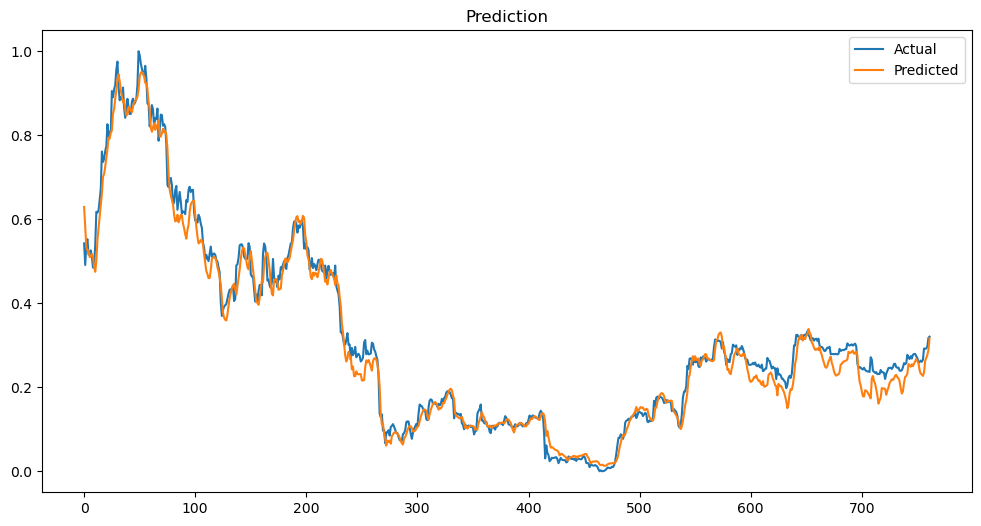

(0.9927276458630416,
 0.9830517539792902,
 0.0009019060803540968,
 0.030031751203586126)

In [8]:
gru_df(df_data, input_var, name = 'all')

Epoch 1/50
89/89 [==============================] - 4s 9ms/step - loss: 0.0478
Epoch 2/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0074
Epoch 3/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 4/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 5/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0014
Epoch 6/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 7/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0015
Epoch 8/50
89/89 [==============================] - 1s 10ms/step - loss: 7.0597e-04
Epoch 9/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 10/50
89/89 [==============================] - 1s 10ms/step - loss: 7.0238e-04
Epoch 11/50
89/89 [==============================] - 1s 10ms/step - loss: 7.5250e-04
Epoch 12/50
89/89 [==============================] - 1s 10ms/step - loss: 5.4387e-04
Epoch 13/50
89/89 [===

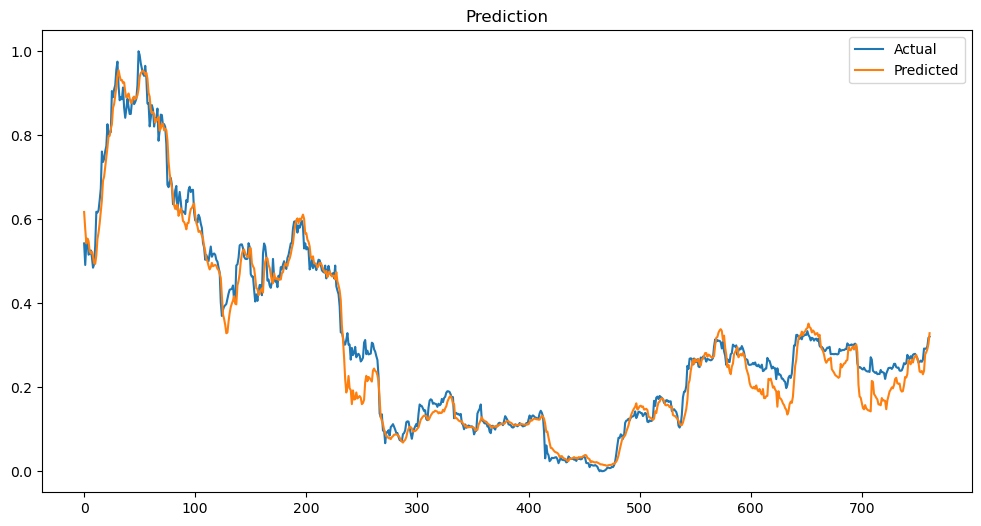

(0.9934880497700248,
 0.9733160836604499,
 0.0014199927452606318,
 0.037682791102313956)

In [44]:
gru_df(df_data, input_var_trends, name = 'trends')

Epoch 1/50
89/89 [==============================] - 4s 11ms/step - loss: 0.0494
Epoch 2/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0130
Epoch 3/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 4/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 5/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 6/50
89/89 [==============================] - 1s 10ms/step - loss: 8.5615e-04
Epoch 7/50
89/89 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 8/50
89/89 [==============================] - 1s 10ms/step - loss: 8.0364e-04
Epoch 9/50
89/89 [==============================] - 1s 10ms/step - loss: 7.5240e-04
Epoch 10/50
89/89 [==============================] - 1s 10ms/step - loss: 8.3488e-04
Epoch 11/50
89/89 [==============================] - 1s 10ms/step - loss: 5.9828e-04
Epoch 12/50
89/89 [==============================] - 1s 10ms/step - loss: 6.1871e-04
Epoch 13/50
8

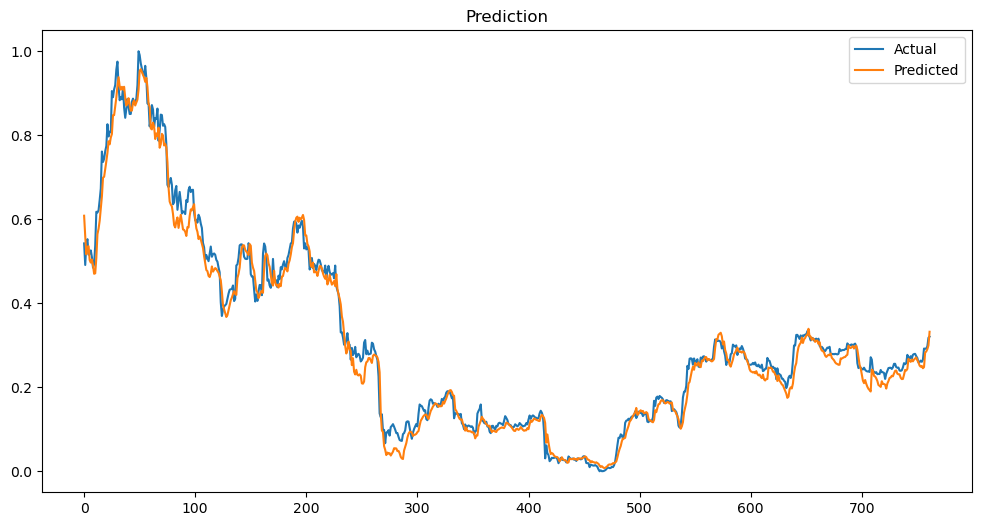

(0.994730177487655,
 0.9843695589724607,
 0.0008317786857783292,
 0.02884057360349009)

In [47]:
gru_df(df_data, input_var_tnv, name = 'trends_volume') 

Epoch 1/50
89/89 [==============================] - 3s 6ms/step - loss: 0.0185
Epoch 2/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0020
Epoch 3/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 4/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0014
Epoch 5/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0012
Epoch 6/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0014
Epoch 7/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0012
Epoch 8/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0013
Epoch 9/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 10/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0011
Epoch 11/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0010
Epoch 12/50
89/89 [==============================] - 1s 6ms/step - loss: 0.0011
Epoch 13/50
89/89 [==============================

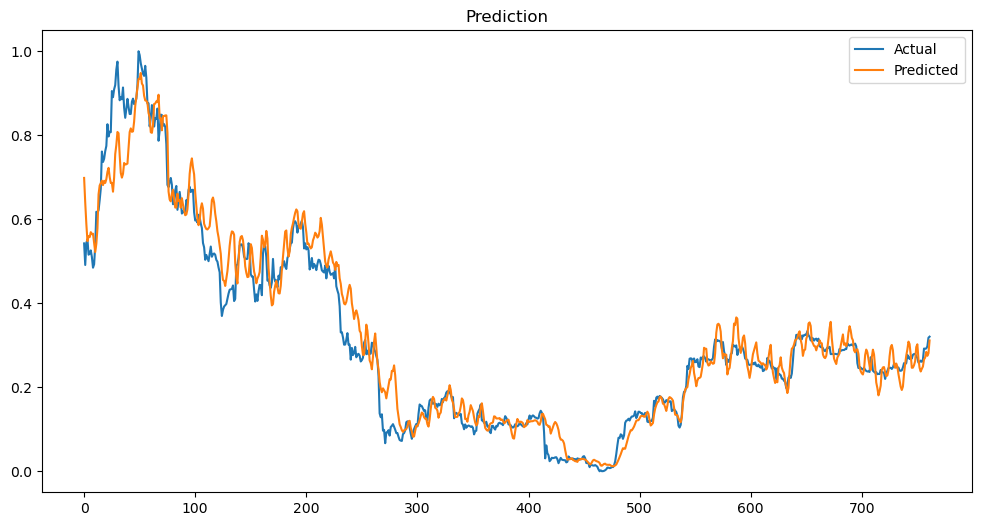

(0.9890630162762537,
 0.9508703853484399,
 0.0026144474257425274,
 0.05113166754314324)

In [51]:
gru_df(df_data, input_var_elasticity, name = 'elasticity')

Epoch 1/50
89/89 [==============================] - 4s 14ms/step - loss: 0.0134
Epoch 2/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 3/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0015
Epoch 4/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0012
Epoch 5/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0010
Epoch 6/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 7/50
89/89 [==============================] - 1s 14ms/step - loss: 9.1166e-04
Epoch 8/50
89/89 [==============================] - 1s 14ms/step - loss: 8.8764e-04
Epoch 9/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0014
Epoch 10/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 11/50
89/89 [==============================] - 1s 14ms/step - loss: 0.0011
Epoch 12/50
89/89 [==============================] - 1s 15ms/step - loss: 0.0010
Epoch 13/50
89/89 [==========

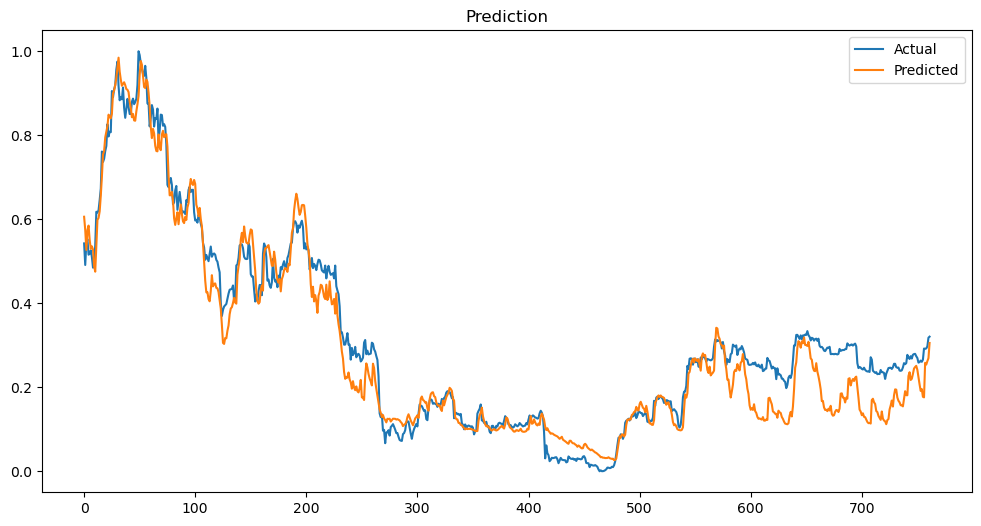

(0.9897277468662019,
 0.9362061899931925,
 0.0033948070534135476,
 0.05826497278308424)

In [52]:
gru_df(df_data, input_var_tnm_plus, name = 'trends_market_plus')

Epoch 1/50
89/89 [==============================] - 4s 11ms/step - loss: 0.0526
Epoch 2/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0126
Epoch 3/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0023
Epoch 4/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0016
Epoch 5/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0013
Epoch 6/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0012
Epoch 7/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0010
Epoch 8/50
89/89 [==============================] - 1s 11ms/step - loss: 6.1811e-04
Epoch 9/50
89/89 [==============================] - 1s 11ms/step - loss: 0.0014
Epoch 10/50
89/89 [==============================] - 1s 11ms/step - loss: 6.4464e-04
Epoch 11/50
89/89 [==============================] - 1s 11ms/step - loss: 5.9242e-04
Epoch 12/50
89/89 [==============================] - 1s 11ms/step - loss: 6.9911e-04
Epoch 13/50
89/89 [==

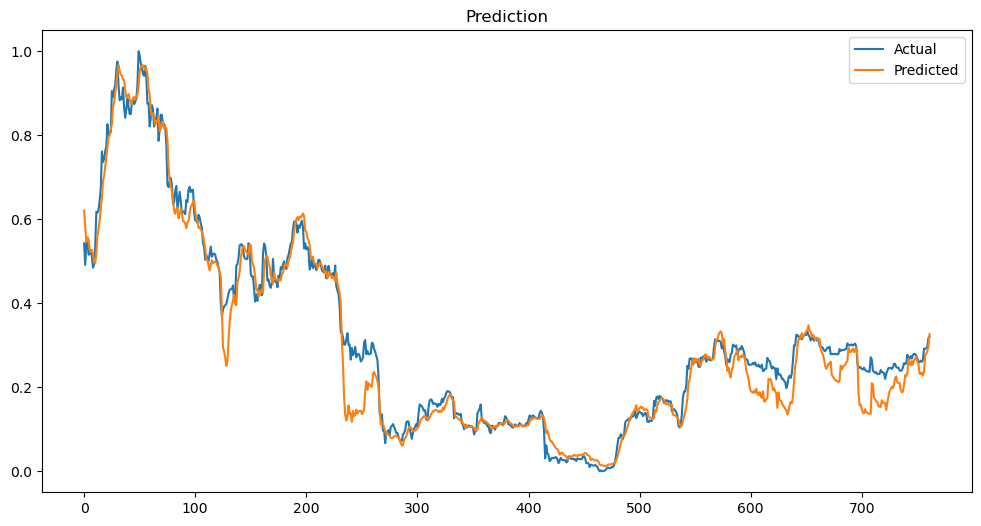

(0.992629210331475,
 0.9633543405725903,
 0.0019501099415113454,
 0.04416004915657755)

In [53]:
gru_df(df_data, input_var_tnm, name = 'trends_market')

Epoch 1/50
89/89 [==============================] - 3s 7ms/step - loss: 0.0229
Epoch 2/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0025
Epoch 3/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0018
Epoch 4/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 5/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 6/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 7/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 8/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 9/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 10/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0012
Epoch 11/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0010
Epoch 12/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 13/50
89/89 [==============================

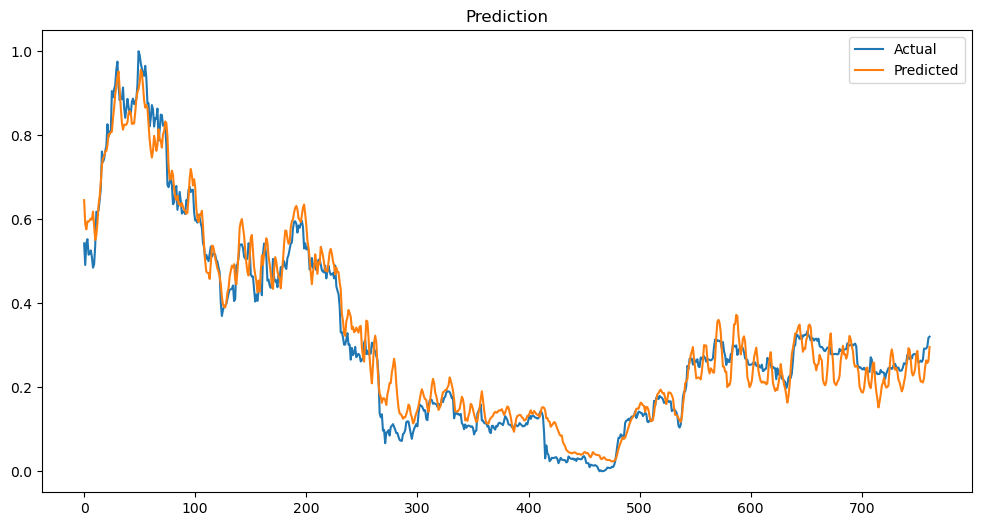

(0.9884787675250254,
 0.9662422760704344,
 0.0017964275733185933,
 0.04238428450874915)

In [54]:
gru_df(df_data, input_var_enm, name = 'elasticity_market')

Epoch 1/50
89/89 [==============================] - 3s 7ms/step - loss: 0.0161
Epoch 2/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0020
Epoch 3/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0018
Epoch 4/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0017
Epoch 5/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0017
Epoch 6/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0018
Epoch 7/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 8/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 9/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 10/50
89/89 [==============================] - 1s 8ms/step - loss: 0.0018
Epoch 11/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0015
Epoch 12/50
89/89 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 13/50
89/89 [==============================

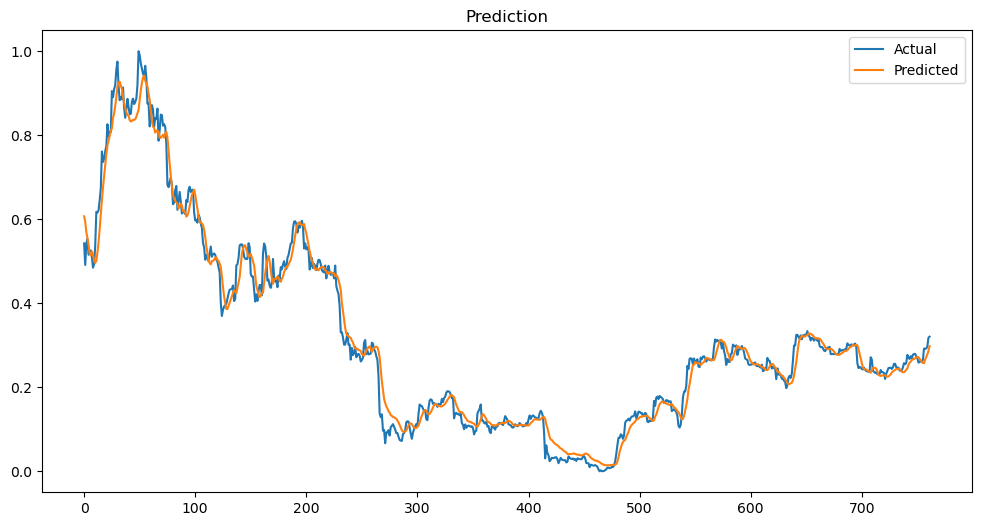

(0.9905729858381493,
 0.9831615460185208,
 0.0008960634635053962,
 0.029934319158875088)

In [55]:
gru_df(df_data, input_var_plus, name = 'plus')

Epoch 1/50
89/89 [==============================] - 3s 5ms/step - loss: 0.0333
Epoch 2/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 3/50
89/89 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4/50
89/89 [==============================] - 0s 5ms/step - loss: 8.1620e-04
Epoch 5/50
89/89 [==============================] - 0s 5ms/step - loss: 6.8933e-04
Epoch 6/50
89/89 [==============================] - 0s 5ms/step - loss: 8.0076e-04
Epoch 7/50
89/89 [==============================] - 0s 5ms/step - loss: 6.2602e-04
Epoch 8/50
89/89 [==============================] - 0s 5ms/step - loss: 4.4995e-04
Epoch 9/50
89/89 [==============================] - 0s 5ms/step - loss: 8.1741e-04
Epoch 10/50
89/89 [==============================] - 0s 5ms/step - loss: 4.9911e-04
Epoch 11/50
89/89 [==============================] - 0s 5ms/step - loss: 3.8665e-04
Epoch 12/50
89/89 [==============================] - 0s 5ms/step - loss: 4.1448e-04
Epoch 13/50
8

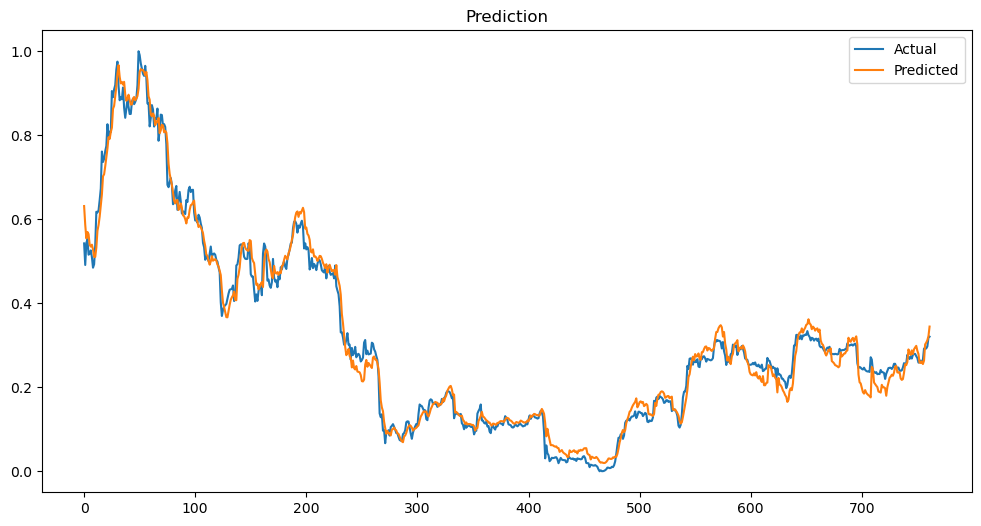

(0.990122668195578,
 0.9850835588218064,
 0.00079378296606138,
 0.028174154220870235)

In [56]:
gru_df(df_data, input_var_close, name = 'only_close')